In [1]:
import os
import torch
from retrievers.mire import MIRe
from retrievers.colbert import ColBERTConfig
from transformers import AutoConfig

mire_ckpt = "ckpts/mire/vid2r/base/mire_pretrained.pth"

dir_name = os.path.dirname(mire_ckpt)
model_cfg = AutoConfig.from_pretrained(dir_name)
model_cfg.pretraining = False
colbert_cfg = ColBERTConfig.load_from_checkpoint(dir_name)

model = MIRe(model_cfg, colbert_cfg)
model.load_state_dict(torch.load(mire_ckpt)["model"])
model.eval()
model.to('cuda:0')

/opt/conda/envs/retxknow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/retxknow/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/opt/conda/envs/retxknow/lib/python3.9/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/opt/conda/envs/retxknow/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be

MIRe(
  (model): HF_ColBERT(
    (linear): Linear(in_features=768, out_features=128, bias=False)
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense)

In [2]:
from retrievers.colbert import QueryTokenizer
query_tokenizer = QueryTokenizer(colbert_cfg)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from dataset.base import ImageDataset
from transformers import CLIPImageProcessor
from torch.utils.data import DataLoader

data_dir = "data/cat_dog"
img_list = os.listdir(data_dir)
img_processor = CLIPImageProcessor.from_pretrained(model_cfg.vision_model_name)
img_dataset = ImageDataset(img_list, data_dir, img_processor=img_processor)
img_dataloader = DataLoader(img_dataset, batch_size=4, shuffle=False, num_workers=4, drop_last=False)
len(img_dataset)

The number of removed data: 0
The number of existing data: 224


224

In [4]:
device = torch.device("cuda:0")

In [5]:
from tqdm import tqdm

question = "What is the dog or puppy's species?"
input_ids = query_tokenizer.tok(['. ' + question], return_tensors="pt").input_ids
input_ids[:, 1] = query_tokenizer.Q_marker_token_id
input_ids[input_ids == query_tokenizer.pad_token_id] = query_tokenizer.mask_token_id
mask = torch.ones((input_ids.size(0), input_ids.size(1)))

input_ids = input_ids.expand(4, -1)

Qs = []
with torch.no_grad():
    for batch in tqdm(img_dataloader):
        images, paths = batch
        input_ids = input_ids.to(device)
        mask = mask.to(device)
        images = images.to(device)
        # query
        Q_t, Q_i = model.embed_VL(input_ids, mask, images)
        Q = model.query(Q_t, Q_i, mask)
        Qs.append(Q.detach().cpu())
        
dog_feats = []
for q in Qs:
    dog_feats.append(q[:,16:28,:].mean(dim=1).detach())
dog_feats = torch.cat(dog_feats, dim=0)

100%|██████████| 56/56 [00:09<00:00,  5.84it/s]


In [6]:
from tqdm import tqdm

question = "What is the cat or kitty's species?"
input_ids = query_tokenizer.tok(['. ' + question], return_tensors="pt").input_ids
input_ids[:, 1] = query_tokenizer.Q_marker_token_id
input_ids[input_ids == query_tokenizer.pad_token_id] = query_tokenizer.mask_token_id
mask = torch.ones((input_ids.size(0), input_ids.size(1)))

input_ids = input_ids.expand(4, -1)

Qs = []
with torch.no_grad():
    for batch in tqdm(img_dataloader):
        images, paths = batch
        input_ids = input_ids.to(device)
        mask = mask.to(device)
        images = images.to(device)
        # query
        Q_t, Q_i = model.embed_VL(input_ids, mask, images)
        Q = model.query(Q_t, Q_i, mask)
        Qs.append(Q.detach().cpu())
        
cat_feats = []
global_feats = []
for q in Qs:
    cat_feats.append(q[:,16:28,:].mean(dim=1).detach())
    global_feats.append(q[:,:16].mean(dim=1).detach())
cat_feats = torch.cat(cat_feats, dim=0)
global_feats = torch.cat(global_feats, dim=0)

100%|██████████| 56/56 [00:08<00:00,  6.42it/s]


In [7]:
from tqdm import tqdm

question = "Where is the place in the image?"
input_ids = query_tokenizer.tok(['. ' + question], return_tensors="pt").input_ids
input_ids[:, 1] = query_tokenizer.Q_marker_token_id
input_ids[input_ids == query_tokenizer.pad_token_id] = query_tokenizer.mask_token_id
mask = torch.ones((input_ids.size(0), input_ids.size(1)))

input_ids = input_ids.expand(4, -1)

Qs = []
with torch.no_grad():
    for batch in tqdm(img_dataloader):
        images, paths = batch
        input_ids = input_ids.to(device)
        mask = mask.to(device)
        images = images.to(device)
        # query
        Q_t, Q_i = model.embed_VL(input_ids, mask, images)
        Q = model.query(Q_t, Q_i, mask)
        Qs.append(Q.detach().cpu())
        
place_feats = []
for q in Qs:
    place_feats.append(q[:,16:28,:].mean(dim=1).detach())
place_feats = torch.cat(place_feats, dim=0)

100%|██████████| 56/56 [00:08<00:00,  6.36it/s]


In [8]:
dog_np = dog_feats.numpy()
cat_np = cat_feats.numpy()
global_np = global_feats.numpy()
place_np = place_feats.numpy()

In [9]:
import numpy as np
import umap
# Combine tensors into one dataset
data = np.vstack((dog_np, cat_np, place_np, global_np))
# Create labels for the classes
labels = np.array([0] * 224 + [1] * 224 + [2] * 224 + [3] * 224)
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.5, n_components=2, random_state=42)
umap_result = umap_model.fit_transform(data)

/opt/conda/envs/retxknow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/retxknow/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


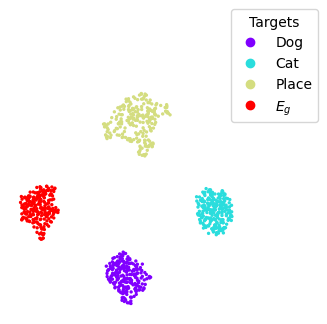

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the results
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
scatter = ax.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='rainbow', s=2, alpha=1.0)
legend_labels = ["Dog", "Cat", "Place", r"$E_g$"]
handles, _ = scatter.legend_elements()
ax.axis(False)
# legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.legend(handles, legend_labels, title="Targets", fontsize=10, title_fontsize=10, bbox_to_anchor=(0.92, 0.8), loc='best')